In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import odl
from odl.contrib import torch as odl_torch
from scipy import sparse
# from Get_Ray_Trafo import get_ray_trafo
from ray_transforms import get_ray_trafo
from util import hide_axis,Timer
from data_set_functions_swaped import get_initial_dataset,append_dataset,get_adj_dataset,get_xis,get_x0s,defs_multiple_RTs, defs_list 
from test_model_functions_swaped import get_net_corected_operator
from util import get_op,sparse_Mat,plots
from gradient_descent import gradient_descent, get_opt_lambda
from Iteration_Steps import get_grad_desc_step

In [5]:
def obj_func(op,y,lam,R,x):
    return 1/(2*lam)*np.linalg.norm((op(x)-y).reshape(y.size),2)**2+R(x)

def im_norm(x):
    if type(x) is odl.discr.discr_space.DiscretizedSpaceElement:
        x= x.asarray()
    x = x.reshape(x.size)
    return np.linalg.norm(x,2)

def sp(a,b):
    return a.reshape(a.size)@b.reshape(b.size)

def get_shift(shift_params):
    def shift(angle):
        for i in range(shift_params.shape[0]):
            u_shift = shift_params[i,0,0]*np.sin(shift_params[i,0,1]*angle+shift_params[i,0,2])
            v_shift = shift_params[i,1,0]*np.sin(shift_params[i,1,1]*angle+shift_params[i,1,2])
        return np.array([u_shift,v_shift]).T
    return shift 

In [6]:
gpu_idx = 0
device = f"cuda:{gpu_idx}" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
import astra
astra.set_gpu_index(gpu_idx)

Using cuda:0 device


In [7]:
tp = np.load(file='phantoms/test_phantoms_64_1.npy')
p = tp[0,:,:]
p.shape

(64, 64)

In [8]:
def im_norm(x):
    if type(x) is odl.discr.discr_space.DiscretizedSpaceElement:
        x= x.asarray()
    x = x.reshape(x.size)
    return np.linalg.norm(x,2)
# Training    
pps = 64
x_res = pps
y_res = pps
n_ang = 256
n_dtp = 96#248

impl = 'astra_cuda'
static_ray_trafo = get_ray_trafo(x_res,y_res,n_ang,n_dtp,detector_len=2,impl=impl)


grad_R=None
shift_params =  np.load("shift_params/strong_u_v_shift.npy")#
shift_params = (np.array([[[0.03,5000,0],[0.03,5000,0]]]))
# grad_R = odl.solvers.L2Norm(static_ray_trafo.domain).gradient
def get_shift(shift_params):
    def shift(angle):
        for i in range(shift_params.shape[0]):
            u_shift = shift_params[i,0,0]*np.sin(shift_params[i,0,1]*angle+shift_params[i,0,2])
            v_shift = shift_params[i,1,0]*np.sin(shift_params[i,1,1]*angle+shift_params[i,1,2])
        return np.array([u_shift,v_shift]).T
    return shift
def rand_shift(angle):
    u_shift = 0*angle+0.1*(np.random.rand()-0.5)
    v_shift = 0*angle+0.1*(np.random.rand()-0.5)

shift = get_shift(shift_params)
ray_trafo = get_ray_trafo(x_res,y_res,n_ang,n_dtp,DET_SHIFT = shift,detector_len=2,impl=impl)
# ray_trafo = get_ray_trafo(x_res,y_res,n_ang,n_dtp,shift_params=shift_params,detector_len=2,impl=impl)


In [17]:
A_s = sparse_Mat(ray_trafo,x_res,y_res,n_ang,n_dtp)
A_static_s = sparse_Mat(static_ray_trafo,x_res,y_res,n_ang,n_dtp)

# A_s=sparse.load_npz('Matritzen/64_64_256_96_strong_u_v_shift.npz')
# A_static_s=sparse.load_npz('Matritzen/64_64_256_96_static.npz')


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:07<00:00, 535.17it/s]


In [18]:
true_op = get_op(A_s,x_res,y_res,n_ang,n_dtp)
ray_trafos=[true_op]

static_op = get_op(A_static_s,x_res,y_res,n_ang,n_dtp)
op_norm2 = np.linalg.norm(A_static_s.todense(),2)**2

In [19]:
R = odl.solvers.Huber(ray_trafo.domain,0.001)*64
grad_R = R.gradient 

In [20]:
lam = 0.0001
mu = 0.0001
num_phant = 1
num_phant_rand = 0
e_p = 0.01
val_defs = defs_list()
tp = np.load('phantoms/'+f'test_phantoms_{pps}_1.npy')
# defs_multiple_RTs(val_defs, np.load('phantoms/'+f'validation_phantoms_{pps}_10.npy'), ray_trafos,
#                   static_op, mu , lam, grad_R,num_phant,num_phant_rand,e_p = e_p, x_0 = None ) #,x_0=np.zeros((pps,pps))

defs_multiple_RTs(val_defs,tp, ray_trafos,
                  static_op, mu , lam, grad_R,num_phant,num_phant_rand,e_p = e_p, x_0 = None ) #,x_0=np.zeros((pps,pps))


num_iterations = 20
# device = 'cuda'
# adj_swaped = True
# fw_swaped = True

In [21]:
lookup = val_defs.lookup
x0_id = lookup.index('x_0')
ye_id = lookup.index('y_e')
mu_id = lookup.index('mu')
lam_id = lookup.index('lambda')
p_idx = lookup.index('phantom')

d = val_defs[0]
p = d[p_idx]
x_0 = d[x0_id]
y_e = d[ye_id]
mu = 0.3#d[mu_id]
lam = 0.0000000004 #d[lam_id]
x = x_0
op = true_op


def F_true_abl(x):
    return true_op.adjoint(true_op(x)-y_e)
def F_static_abl(x):
    return static_op.adjoint(static_op(x)-y_e)

true_step = get_grad_desc_step(F_true_abl,mu,lam,grad_R,False)  
static_step = get_grad_desc_step(F_static_abl,mu,lam,grad_R,False)


In [22]:
mu,lam


(0.3, 4e-10)

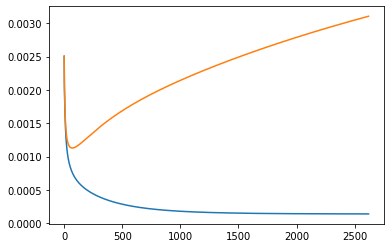

In [23]:
x = x_0
x_static = x_0
loss = list()
loss_static = list()
num_iter = 3000
for i in range(num_iter):
    x_old = x
    x = true_step(x)
    x_static = static_step(x_static)
    loss.append(im_norm(x-p))
    loss_static.append(im_norm(x_static-p))
    # fig,ax =plt.subplots()
    # ax.imshow(x)
    # plt.show(fig)
    if im_norm(x-x_old)<10**-4:
        break

loss = np.array(loss)
loss_static = np.array(loss_static)
fig,ax =plt.subplots()
ax.plot(loss/p.size)
ax.plot(loss_static/p.size)
# ax.set_yscale('log')
plt.show(fig)


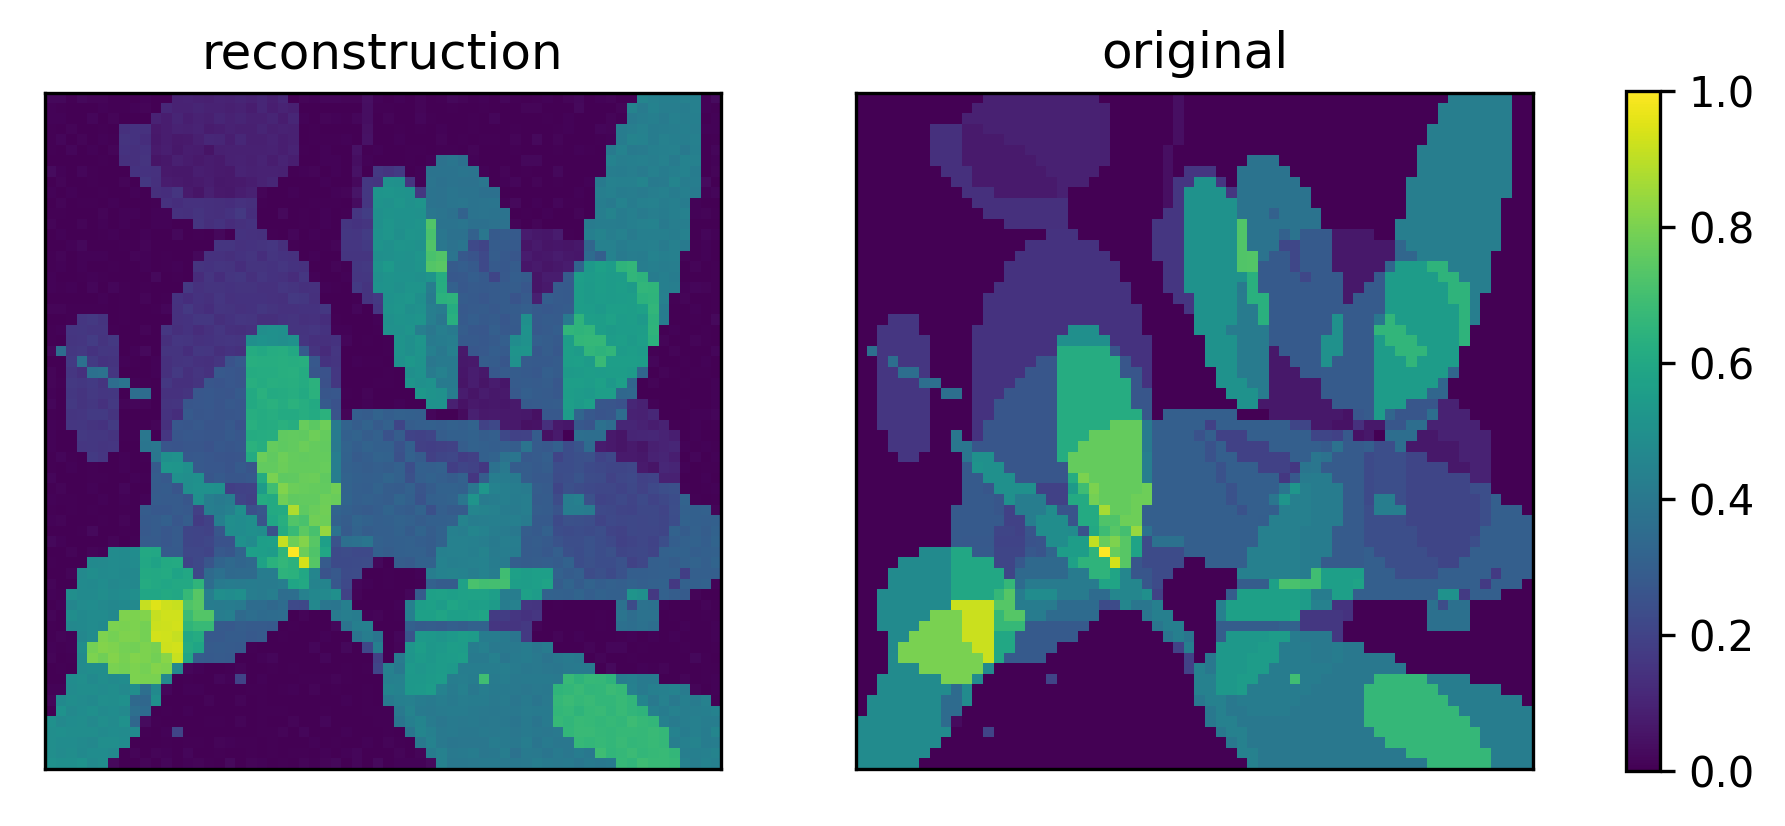

In [24]:
fig,ax = plots(1,2,4/3)
ax[0].imshow(x,vmin=0,vmax=1)
ax[0].set_title('reconstruction')
im = ax[1].imshow(p,vmin=0,vmax=1)  
ax[1].set_title('original')
fig.set_label = f'{num_iter} iterations,mu:{mu} lam:{lam}' 
hide_axis(fig)
fig.colorbar(im, ax=ax)
fig.set_dpi(300)
plt.show(fig)

In [105]:
lookup = val_defs.lookup
x0_id = lookup.index('x_0')
ye_id = lookup.index('y_e')
mu_id = lookup.index('mu')
lam_id = lookup.index('lambda')
p_idx = lookup.index('phantom')

d = val_defs[0]
p = d[p_idx]
x_0 = d[x0_id]
y_e = d[ye_id]
tracker = [np.inf,0,0]
op = true_op
num_iter = 100
num_search = 10
j = 0
for mu in np.logspace(0,-5,num_search):
        j = j+1
        for lam in np.logspace(0,-5,num_search):
                x = x_0
                lam = lam*op_norm2
                GD_step = get_grad_desc_step(F_true_abl,mu,lam,grad_R,False) 
                for i in range(num_iter):
                        x = GD_step(x)
                        loss = (np.linalg.norm((x-p).reshape(p.size))/p.size)
                if tracker[0]>loss:
                        tracker = [loss,mu,lam]
                        print(f'{100*j/num_search:0}% | {tracker}',end="\r")
        print(f'{100*j/num_search:0}% | {tracker}',end="\r")



In [10]:
from Iteration_Steps import get_grad_desc_step,get_ISTA_step,get_F_abl_normed

In [11]:
F_static_abl_list = list()
F_abl_list = list()
norm = static_ray_trafo.norm(estimate=True)
for y_e in Y_e:
    F_static_abl_list.append(get_F_abl_normed(static_ray_trafo,y_e,norm=norm))
    F_abl_list.append(get_F_abl_normed(ray_trafo,y_e,norm=norm))



15.2186890806
17.9521854807
13.4502723298
11.1005344201
17.2681289488
17.8702293
18.4346722596
16.2023764889
15.9968898935
16.4614995781
12.6884291225
20.5742334037
15.3235518186
16.5157478995
15.6608411934
14.1500892612
22.4349032847
22.8054963856
20.0015304229
15.9686159971


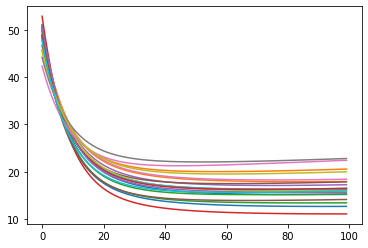

In [8]:
num_iter = 100
for j,F_abl in enumerate(F_static_abl_list):
    loss = list()
    x = np.ones((64,64))
    grad_desc_step = get_grad_desc_step(F_abl,0.1,0.001,grad_R)
    for i in range(num_iter):
        x = grad_desc_step(x)
        loss.append(np.linalg.norm((x-P[j]).reshape(P[j].size)))
    print(loss[-1])
    plt.plot(loss)

16.1957717029
18.8942600175
14.4034811455
12.3277174245
18.0063713282
18.1892545197
19.1777996469
17.0937590241
17.0126127251
17.2368568564
13.8661897717
20.6565417739
15.9306997058
17.0672293016
16.588277901
14.7302644056
21.9301897554
22.6721387135
20.2115960242
16.3692409304


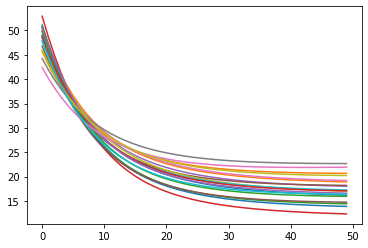

In [9]:
num_iter = 50
for j,F_abl in enumerate(F_static_abl_list):
    loss = list()
    x = np.ones((64,64))
    grad_desc_step = get_grad_desc_step(F_abl,0.1,0.01,grad_R)
    for i in range(num_iter):
        x = grad_desc_step(x)
        loss.append(np.linalg.norm((x-P[j]).reshape(P[j].size)))
    print(loss[-1])
    plt.plot(loss)

15.6459131266
18.3249357999
13.7615074324
11.7183163381
17.40266284
17.5343858317
18.572983362
16.5774723964
16.4391949508
16.6117700801
13.2117367762
20.0196443867
15.2992160825
16.4447135857
16.0472277494
14.0410316328
21.2409441182
22.0287570525
19.5538241677
15.70239068


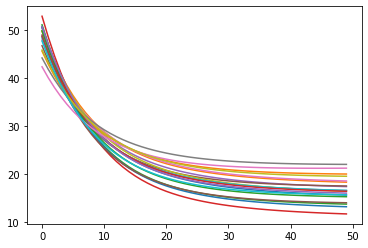

In [10]:
num_iter = 50
for j,F_abl in enumerate(F_static_abl_list):
    loss = list()
    x = np.ones((64,64))
    grad_desc_step = get_grad_desc_step(F_abl,0.1,0.0001,grad_R)
    for i in range(num_iter):
        x = grad_desc_step(x)
        loss.append(np.linalg.norm((x-P[j]).reshape(P[j].size)))
    print(loss[-1])
    plt.plot(loss)

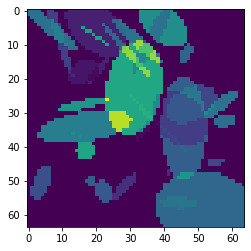

In [11]:
plt.imshow(P[0])

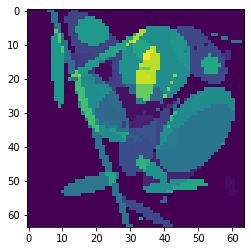

In [12]:
plt.imshow(P[1])

In [13]:
num_iter = 100
for j,F_abl in enumerate(F_static_abl_list):
    loss = list()
    x = np.ones((64,64))
    ISTA_step = get_ISTA_step(F_abl,0.1,0.1)
    for i in range(num_iter):
        x = ISTA_step(x)
        loss.append(np.linalg.norm((x-P[j]).reshape(P[j].size)))
    print(loss[-1])
    plt.plot(loss)

TypeError: unsupported operand type(s) for *: 'float' and 'function'

In [ ]:
ISTA

In [ ]:
print(a)

None


In [12]:
y_e = static_ray_trafo(P[0]).asarray()

In [14]:
from matplotlib.animation import ArtistAnimation

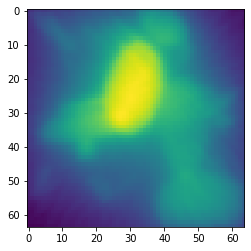

In [34]:
fig = plt.figure()

z = np.zeros((64,64))
# z[0,:] = y[0,:]
frames = list()
for i in range(64):
    z[i,:]=y_e[i,:]
    im = plt.imshow(static_ray_trafo.adjoint(z).asarray(),animated = True)
    frames.append([im])

ani = ArtistAnimation(fig, frames, interval=50,blit=True, repeat_delay=1000)
ani.save('RT_adjoint_added.mp4')
plt.show()

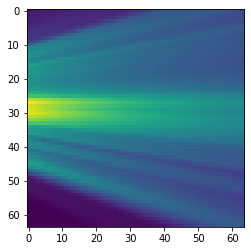

In [37]:
fig = plt.figure()

# z[0,:] = y[0,:]
frames = list()
for i in range(64):
    z = np.zeros((64,64))
    z[i,:]=y_e[i,:]
    im = plt.imshow(static_ray_trafo.adjoint(z).asarray(),animated = True)
    frames.append([im])

ani = ArtistAnimation(fig, frames, interval=50,blit=True, repeat_delay=1000)
ani.save('RT_adjoint.mp4')
plt.show()

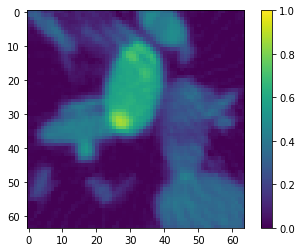

In [49]:
fig = plt.figure()

# z[0,:] = y[0,:]
z = np.zeros((64,64))
frames = list()
x = static_ray_trafo.adjoint(y_e).asarray()
x = z
for j in range(20):
    z = np.zeros((64,64))
    r = static_ray_trafo(x)-y_e
    for i in range(64):
        z[i,:]=r[i,:]
        im = plt.imshow(x-0.1*static_ray_trafo.adjoint(z).asarray(),animated = True,vmin=0,vmax=1)
        frames.append([im])
    x = x-0.1*static_ray_trafo.adjoint(z).asarray()
plt.colorbar()
ani = ArtistAnimation(fig, frames, interval=50,blit=True, repeat_delay=1000)
ani.save('RT_step20_from0_added.mp4')
plt.show()

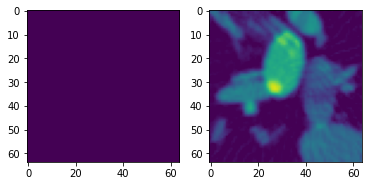

In [55]:
fig, axs = plt.subplots(1,2)

# z[0,:] = y[0,:]

x = static_ray_trafo.adjoint(y_e)
frames = list()
for j in range(20):
    r = static_ray_trafo(x)-y_e
    h = np.zeros((64,64))
    for i in range(64):
        z = np.zeros((64,64))
        z[i,:]=r[i,:]
        h[i,:]=r[i,:]
        im1 = axs[0].imshow(static_ray_trafo.adjoint(z).asarray(),animated = True,vmin=0,vmax=1)
        im2 = axs[1].imshow(x-0.1*static_ray_trafo.adjoint(h).asarray(),animated = True,vmin=0,vmax=1)
        frames.append([im1,im2])
    x = x-0.1*static_ray_trafo.adjoint(h).asarray()
ani = ArtistAnimation(fig, frames, interval=50,blit=True, repeat_delay=1000)
ani.save('RT_20steps_both.mp4')
plt.show()